In [1]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
import xgboost as xgb
import tensorflow as tf

nltk.download("stopwords")
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mevan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Data loading

In [2]:
data = pd.read_csv("elearn_recommendation.csv")
data.head()

C:\Users\mevan\AppData\Local\Temp\ipykernel_9024\790768607.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("elearn_recommendation.csv")


,Unnamed: 0,course_id,name,rating,reviews,Platform,institution,course_url,actual_sentiment
0,0,financial-markets-global,Financial Markets,3.0,"I really liked this class, practice lab assign...",Coursera,Not Available,Not Available,0
1,1,financial-markets-global,Financial Markets,3.0,Prof Steve Joordens is an excellent teacher an...,Coursera,Not Available,Not Available,0
2,2,financial-markets-global,Financial Markets,4.0,"In the beginning, I found the instructor ...",Coursera,Not Available,Not Available,1
3,3,financial-markets-global,Financial Markets,4.0,It was an excellent and perfect course fo...,Coursera,Not Available,Not Available,1
4,4,financial-markets-global,Financial Markets,4.0,Murtaza Haider's readings were enjoyable ...,Coursera,Not Available,Not Available,1


In [3]:
data.shape

(443342, 9)

In [4]:
data = data.drop_duplicates()
data.shape

(443342, 9)

In [5]:
data["Platform"].unique()

array(['Coursera', 'Udemy ', nan], dtype=object)

In [6]:
data.isna().sum()

Unnamed: 0            0
course_id             0
name                  0
rating                0
reviews              86
Platform            829
institution           0
course_url            0
actual_sentiment      0
dtype: int64

In [7]:
data.value_counts("Platform")

Platform
Coursera    259955
Udemy       182558
Name: count, dtype: int64

In [8]:
data["Platform"] = data["Platform"].fillna("Udemy")

In [9]:
data["institution"].value_counts()

institution
Not Available    443342
Name: count, dtype: int64

In [10]:
data["Platform"] = data["Platform"].replace("Coursera", "Coursera")
data["Platform"] = data["Platform"].replace("Udemy ", "Udemy")

In [11]:
data.columns

Index(['Unnamed: 0', 'course_id', 'name', 'rating', 'reviews', 'Platform',
       'institution', 'course_url', 'actual_sentiment'],
      dtype='object')

In [12]:
data["course_url"].nunique()

1

In [13]:
data = data.drop(["Unnamed: 0", "institution", "course_url"], axis=1)


data["course_id"] = data["course_id"].astype(str)
data["name"] = data["name"].astype(str)
data["rating"] = data["rating"].astype(float)
data["reviews"] = data["reviews"].astype(str)
data["Platform"] = data["Platform"].astype(str)
data["actual_sentiment"] = data["actual_sentiment"].astype(int)

In [14]:
data.head()

,course_id,name,rating,reviews,Platform,actual_sentiment
0,financial-markets-global,Financial Markets,3.0,"I really liked this class, practice lab assign...",Coursera,0
1,financial-markets-global,Financial Markets,3.0,Prof Steve Joordens is an excellent teacher an...,Coursera,0
2,financial-markets-global,Financial Markets,4.0,"In the beginning, I found the instructor ...",Coursera,1
3,financial-markets-global,Financial Markets,4.0,It was an excellent and perfect course fo...,Coursera,1
4,financial-markets-global,Financial Markets,4.0,Murtaza Haider's readings were enjoyable ...,Coursera,1


In [15]:
data["Platform"].value_counts()

Platform
Coursera    259955
Udemy       183387
Name: count, dtype: int64

In [16]:
data = data.drop_duplicates()

#EDA

In [17]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#Visualization

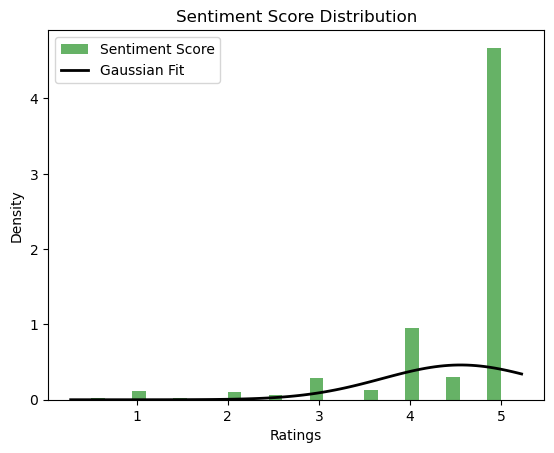

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

sentiment_scores = data["rating"]

# Plot histogram
plt.hist(
    sentiment_scores,
    bins=30,
    density=True,
    alpha=0.6,
    color="g",
    label="Sentiment Score",
)

# Calculate mean and standard deviation
mu, std = norm.fit(sentiment_scores)

# Plot Gaussian distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2, label="Gaussian Fit")

plt.xlabel("Ratings")
plt.ylabel("Density")
plt.title("Sentiment Score Distribution")
plt.legend()
plt.show()

#Data Preprocessing

In [19]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

#Lemmatization, Tokenization, and Stop Words Removal

In [20]:
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")

In [21]:
def text_prep(x):
    corp = str(x).lower()
    corp = re.sub("[^a-zA-Z]+", " ", corp).strip()
    tokens = word_tokenize(corp)
    words = [t for t in tokens if t not in stop_words]
    lemmatize = [lemma.lemmatize(w) for w in words]
    return lemmatize

In [22]:
preprocess_tag = [text_prep(i) for i in data["reviews"]]
data["preprocessed"] = preprocess_tag

In [23]:
data.head()

,course_id,name,rating,reviews,Platform,actual_sentiment,preprocessed
0,financial-markets-global,Financial Markets,3.0,"I really liked this class, practice lab assign...",Coursera,0,"[really, liked, class, practice, lab, assignme..."
1,financial-markets-global,Financial Markets,3.0,Prof Steve Joordens is an excellent teacher an...,Coursera,0,"[prof, steve, joordens, excellent, teacher, dr..."
2,financial-markets-global,Financial Markets,4.0,"In the beginning, I found the instructor ...",Coursera,1,"[beginning, found, instructor, little, difficu..."
3,financial-markets-global,Financial Markets,4.0,It was an excellent and perfect course fo...,Coursera,1,"[excellent, perfect, course, understanding, re..."
4,financial-markets-global,Financial Markets,4.0,Murtaza Haider's readings were enjoyable ...,Coursera,1,"[murtaza, haider, reading, enjoyable, really, ..."


#Feature Extraction

#Word2Vec

In [24]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

In [25]:
data.head()

,course_id,name,rating,reviews,Platform,actual_sentiment,preprocessed
0,financial-markets-global,Financial Markets,3.0,"I really liked this class, practice lab assign...",Coursera,0,"[really, liked, class, practice, lab, assignme..."
1,financial-markets-global,Financial Markets,3.0,Prof Steve Joordens is an excellent teacher an...,Coursera,0,"[prof, steve, joordens, excellent, teacher, dr..."
2,financial-markets-global,Financial Markets,4.0,"In the beginning, I found the instructor ...",Coursera,1,"[beginning, found, instructor, little, difficu..."
3,financial-markets-global,Financial Markets,4.0,It was an excellent and perfect course fo...,Coursera,1,"[excellent, perfect, course, understanding, re..."
4,financial-markets-global,Financial Markets,4.0,Murtaza Haider's readings were enjoyable ...,Coursera,1,"[murtaza, haider, reading, enjoyable, really, ..."


In [26]:
data["flattened_reviews"] = data["preprocessed"].apply(lambda x: " ".join(x))
data.head()

,course_id,name,rating,reviews,Platform,actual_sentiment,preprocessed,flattened_reviews
0,financial-markets-global,Financial Markets,3.0,"I really liked this class, practice lab assign...",Coursera,0,"[really, liked, class, practice, lab, assignme...",really liked class practice lab assignment exc...
1,financial-markets-global,Financial Markets,3.0,Prof Steve Joordens is an excellent teacher an...,Coursera,0,"[prof, steve, joordens, excellent, teacher, dr...",prof steve joordens excellent teacher drive cl...
2,financial-markets-global,Financial Markets,4.0,"In the beginning, I found the instructor ...",Coursera,1,"[beginning, found, instructor, little, difficu...",beginning found instructor little difficult un...
3,financial-markets-global,Financial Markets,4.0,It was an excellent and perfect course fo...,Coursera,1,"[excellent, perfect, course, understanding, re...",excellent perfect course understanding researc...
4,financial-markets-global,Financial Markets,4.0,Murtaza Haider's readings were enjoyable ...,Coursera,1,"[murtaza, haider, reading, enjoyable, really, ...",murtaza haider reading enjoyable really struck...


In [27]:
X_data, y_data = np.array(data["flattened_reviews"]), np.array(data["actual_sentiment"])

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=0
)
print("Data Split done.")

Data Split done.


In [28]:
data.head()

,course_id,name,rating,reviews,Platform,actual_sentiment,preprocessed,flattened_reviews
0,financial-markets-global,Financial Markets,3.0,"I really liked this class, practice lab assign...",Coursera,0,"[really, liked, class, practice, lab, assignme...",really liked class practice lab assignment exc...
1,financial-markets-global,Financial Markets,3.0,Prof Steve Joordens is an excellent teacher an...,Coursera,0,"[prof, steve, joordens, excellent, teacher, dr...",prof steve joordens excellent teacher drive cl...
2,financial-markets-global,Financial Markets,4.0,"In the beginning, I found the instructor ...",Coursera,1,"[beginning, found, instructor, little, difficu...",beginning found instructor little difficult un...
3,financial-markets-global,Financial Markets,4.0,It was an excellent and perfect course fo...,Coursera,1,"[excellent, perfect, course, understanding, re...",excellent perfect course understanding researc...
4,financial-markets-global,Financial Markets,4.0,Murtaza Haider's readings were enjoyable ...,Coursera,1,"[murtaza, haider, reading, enjoyable, really, ...",murtaza haider reading enjoyable really struck...


In [29]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words("english")]
    text = " ".join(text)
    return text


data["flattened_reviews"] = data["flattened_reviews"].apply(clean_text)

In [30]:
data.head()

,course_id,name,rating,reviews,Platform,actual_sentiment,preprocessed,flattened_reviews
0,financial-markets-global,Financial Markets,3.0,"I really liked this class, practice lab assign...",Coursera,0,"[really, liked, class, practice, lab, assignme...",really liked class practice lab assignment exc...
1,financial-markets-global,Financial Markets,3.0,Prof Steve Joordens is an excellent teacher an...,Coursera,0,"[prof, steve, joordens, excellent, teacher, dr...",prof steve joordens excellent teacher drive cl...
2,financial-markets-global,Financial Markets,4.0,"In the beginning, I found the instructor ...",Coursera,1,"[beginning, found, instructor, little, difficu...",beginning found instructor little difficult un...
3,financial-markets-global,Financial Markets,4.0,It was an excellent and perfect course fo...,Coursera,1,"[excellent, perfect, course, understanding, re...",excellent perfect course understanding researc...
4,financial-markets-global,Financial Markets,4.0,Murtaza Haider's readings were enjoyable ...,Coursera,1,"[murtaza, haider, reading, enjoyable, really, ...",murtaza haider reading enjoyable really struck...


In [31]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

In [ ]:
# Defining the model input length.
input_length = 100

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_length = 50000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

In [ ]:
X_train

In [ ]:
y = data["actual_sentiment"] + 1
y

# Sentiment Classification

## Elman RNN

In this code, SimpleRNN layer replaces the LSTM layer. SimpleRNN is a basic type of RNN that uses the Elman recurrent unit. It's simpler compared to LSTM and doesn't have mechanisms like gates to control information flow, making it computationally less expensive but potentially less effective for capturing long-range dependencies. However, for simpler tasks, it can still perform well.


In [39]:
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    SimpleRNN,
    Conv1D,
    GlobalMaxPool1D,
    Dense,
)
from tensorflow.keras.models import Sequential


def getModel():
    embedding_layer = Embedding(
        input_dim=vocab_length,
        output_dim=Embedding_dimensions,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=False,
    )

    model = Sequential(
        [
            embedding_layer,
            SimpleRNN(100, dropout=0.3, return_sequences=True),
            LSTM(100, dropout=0.3, return_sequences=True),
            Conv1D(100, 5, activation="relu"),
            GlobalMaxPool1D(),
            Dense(16, activation="relu"),
            Dense(1, activation="sigmoid"),
        ],
        name="Sentiment_Model",
    )

    return model

In [40]:
training_model = getModel()
training_model.summary()


Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          6000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 100)          20100     
                                                                 
 lstm (LSTM)                 (None, 100, 100)          80400     
                                                                 
 conv1d (Conv1D)             (None, 96, 100)           50100     
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                  

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=0),
    EarlyStopping(monitor="val_accuracy", min_delta=1e-4, patience=5),
]

In [42]:
training_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [43]:
history = training_model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10


312/312 [==============================] - 375s 1s/step - loss: 0.4117 - accuracy: 0.8903 - val_loss: 0.4043 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 2/10
312/312 [==============================] - 373s 1s/step - loss: 0.3971 - accuracy: 0.8906 - val_loss: 0.3977 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 3/10
312/312 [==============================] - 378s 1s/step - loss: 0.3897 - accuracy: 0.8886 - val_loss: 0.3867 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 4/10
312/312 [==============================] - 395s 1s/step - loss: 0.3843 - accuracy: 0.8866 - val_loss: 0.3876 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 5/10
312/312 [==============================] - 375s 1s/step - loss: 0.3799 - accuracy: 0.8850 - val_loss: 0.3775 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 6/10
312/312 [==============================] - 375s 1s/step - loss: 0.3768 - accuracy: 0.8839 - val_loss: 0.3751 - val_accuracy: 0.8779 - lr: 0.0010


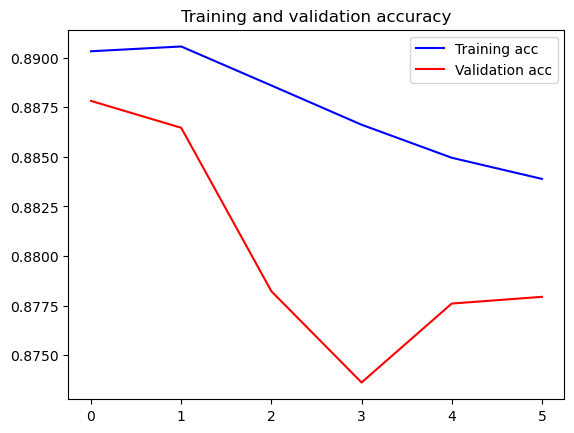

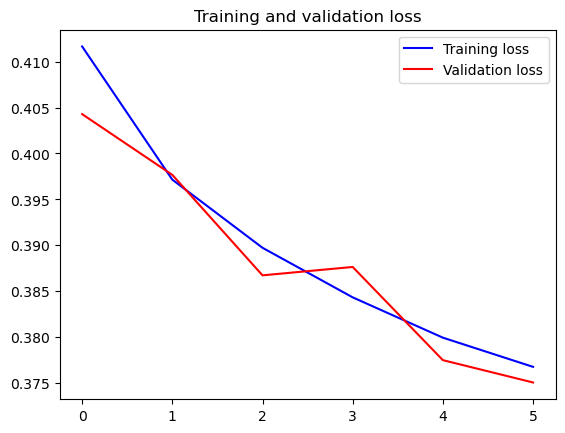

In [44]:
acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
loss, val_loss = history.history["loss"], history.history["val_loss"]
epochs = range(len(acc))

plt.plot(epochs, acc, "b", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [45]:
# Evaluate the model
loss, accuracy = training_model.evaluate(X_test, y_test, verbose=0)
print(f"RNN Accuracy: {accuracy * 100:.2f}%")
print(f"RNN Loss" , loss)

RNN Accuracy: 87.93%
RNN Loss 0.37023091316223145


#Evaluation

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    # categories  = ['Negative','Nuetral','Positive']
    # group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]


    sns.heatmap(
        cf_matrix,
        cmap="Blues",
        fmt="",
    )

    plt.xlabel("Predicted values", fontdict={"size": 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={"size": 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={"size": 18}, pad=20)

In [47]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

2771/2771 [==============================] - 102s 37ms/step


In [ ]:
# create a function that takes a sentence and returns the sentiment
def predict_sentiment(sentence):
    sentence = clean_text(sentence)
    sequence = tokenizer.texts_to_sequences([sentence])
    sequence = pad_sequences(sequence, maxlen=input_length)
    prediction = training_model.predict(sequence)
    if prediction > 0.3:
        return "Positive"
    elif prediction < 0.3 and prediction > -0.3:
        return "Neutral"
    else:
        return "Negative"

data["score"] = data["reviews"].apply(predict_sentiment)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - ETA: 0s

In [1]:
data.to_csv("elearn_recommendation.csv", index=False)